# Concept Drift Detection and Model Retraining

Using the ECOICOP product and category data this notebook attempts to create concept drift and retrain a model based on drift that has been detected

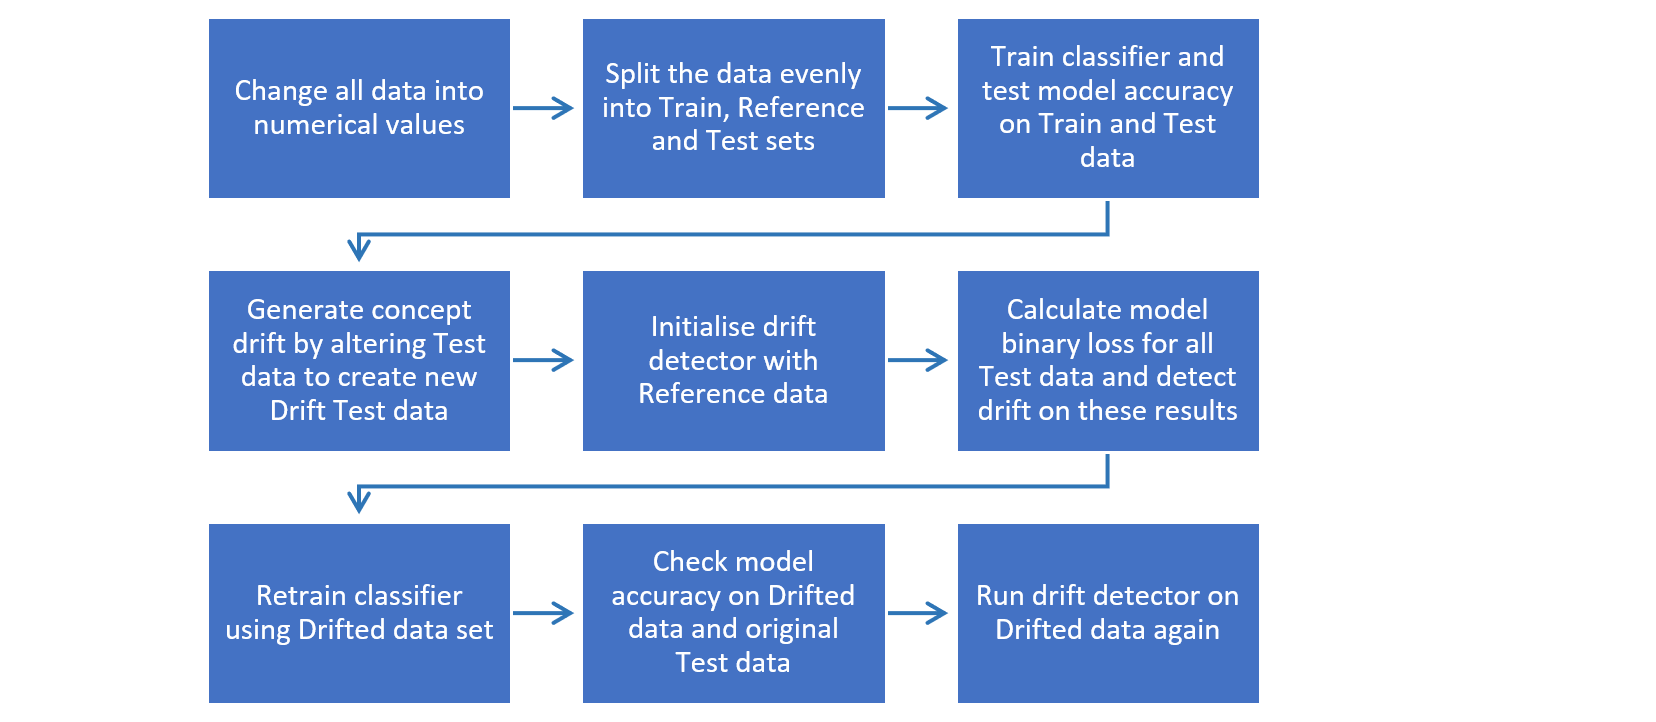

Import packages and data

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from alibi_detect.cd import MMDDrift, FETDrift, CVMDrift, KSDrift

In [2]:
t1 = pd.read_excel(r'\\MDATA1\davies10$\My Documents\DriftDataTimes.xlsx', sheet_name = 'Original Data')
t1

,produkt,kategoria
0,Hejki - Emotes handmade lollipops with fruit f...,Confectionery products
1,100% Pur jus d orange orange juice with pulp ...,Fruit and vegetable juices
2,100% sucralose without sugar (sweeteners),Artificial sugar substitutes
3,100% peach fruit product sweetened with grape ...,"Jams, marmalades and honey"
4,100% blackcurrant fruit product sweetened with...,"Jams, marmalades and honey"
...,...,...
17094,Żywiec Zdrój with apple flavor Non-carbonated ...,Mineral or spring waters
17095,Żywiec Zdrój with strawberry flavor Non-carbon...,Mineral or spring waters
17096,Element - Gently sparkling spring water,Mineral or spring waters
17097,Element - Sparkling spring water,Mineral or spring waters


Create a new dataframe from the original with any Product containing the word pizza having its Category changed to "Pizza"

In [3]:
changes = t1[t1['produkt'].str.contains('Pizza')].copy(deep=True).reset_index(drop=True)
changes['kategoria'] = 'Pizza'
changes
#maybe save old category for later use

,produkt,kategoria
0,American Style Ham and Mushroom Pizza 423 g,Pizza
1,American Style Pepperoni Pizza 404 g,Pizza
2,American Style Quattro Formaggi Pizza 395 g,Pizza
3,Pizza roll 75 g,Pizza
4,Capricciosa Pizza 384 g,Pizza
...,...,...
76,Value Pizza Speciale 1 kg,Pizza
77,Value Pizza with mushrooms 300 g,Pizza
78,Value Pizza with salami 300 g,Pizza
79,Value Pizza with ham 300 g,Pizza


Transform rows under Products into bag of words to get word features

In [4]:
vectorizer = CountVectorizer(token_pattern='\w\w+|[1-9]\.[1-9]\%|[1-9]\,[1-9]\%|[1-9]\.[1-9]|[1-9]\,[1-9]|[1-9]\%',  max_features=500)
vectorizer.fit(t1['produkt'])
X = pd.DataFrame(vectorizer.transform(t1["produkt"]).todense(), columns=vectorizer.get_feature_names()).to_numpy()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Replace Categories with numerical values so we are working with numerical values only

In [5]:
Y = t1['kategoria']
Ys = np.unique(t1['kategoria'])
Ys = dict(zip(Ys, range(len(Ys))))
Y = Y.map(Ys).to_numpy()
print(t1['kategoria'],"\nBecomes\n",Y)

0              Confectionery products
1          Fruit and vegetable juices
2        Artificial sugar substitutes
3          Jams, marmalades and honey
4          Jams, marmalades and honey
                     ...             
17094        Mineral or spring waters
17095        Mineral or spring waters
17096        Mineral or spring waters
17097        Mineral or spring waters
17098        Mineral or spring waters
Name: kategoria, Length: 17099, dtype: object 
Becomes
 [10 30  0 ... 34 34 34]


So any row with the same category will now just have the same numeric value instead

## Splitting Data into Training, Reference and Testing

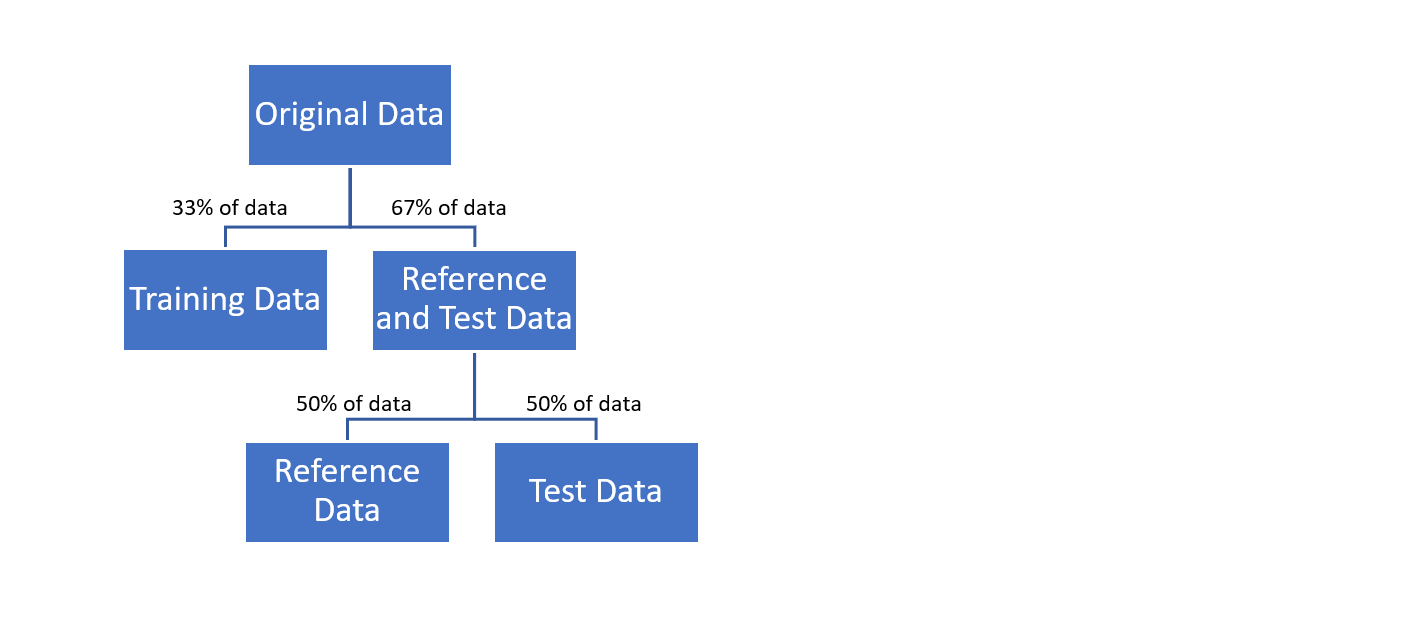

Data for both X and Y values is split equally between Training data, Reference data and Testing data 

In [6]:
Xtrain, Xref, Ytrain, Yref = train_test_split(X, Y, train_size=0.33, random_state=42)
Xref, Xtest, Yref, Ytest = train_test_split(Xref, Yref, train_size=0.5, random_state=42)

A Multinomial Naive Bayes classifier is trained using the X and Y training data
<br>
This is then used to predict labels for both the Training and Testing data

In [35]:
clf = MultinomialNB()
clf.partial_fit(Xtrain, Ytrain, classes=np.unique(Ytrain))

MultinomialNB()

In [36]:
train_predictions = clf.predict(Xtrain)
test_predictions = clf.predict(Xtest)

In [37]:
print("Model training accuracy: ", accuracy_score(Ytrain, train_predictions))
print("Model test accuracy: ", accuracy_score(Ytest, test_predictions))

Model training accuracy:  0.7913860333215172
Model test accuracy:  0.7500436376330948


Whilst a higher accuracy on the training data would be ideal, the accuracy for both sets of data are similar. Therefore the model is capable of predicting labels well enough on new data

## Generate different forms of Concept Drift

Generate concept drift in different ways based on the Test data

Concept Drift 1:
<br>
Randomly select 2 numeric category labels and swap them around

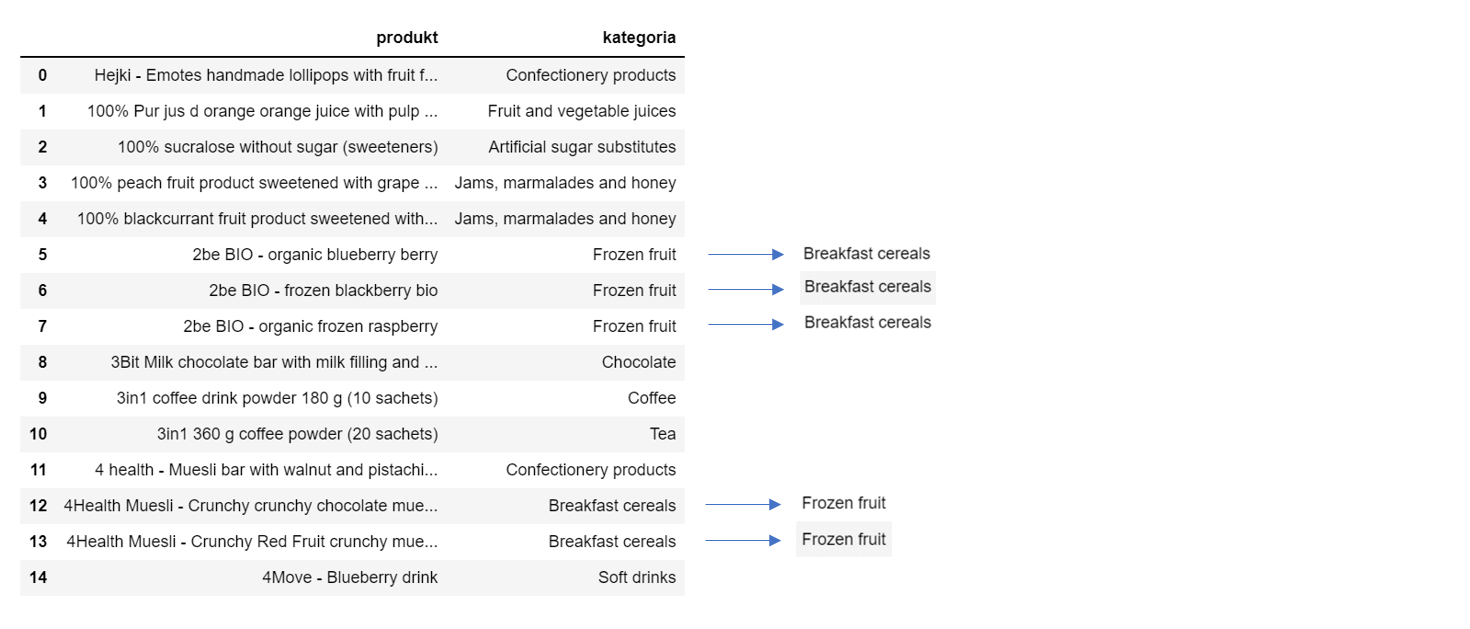

In [19]:
k=np.random.choice(np.unique(Ytest), 2, replace=False)
print(k)

[ 7 18]


In [20]:
XconSwap, YconSwap = Xtest.copy(), Ytest.copy()
idx1 = np.argwhere(Ytest==k[0])
idx2 = np.argwhere(Ytest==k[1])
YconSwap[idx1] = k[1]
YconSwap[idx2] = k[0]

Concept Drift 2:
<br>
Add the changes made, which intoduced the Pizza category, onto the test data whilst keeping the old category as well

In [21]:
changes = pd.concat([changes]*10, ignore_index=True)

In [22]:
XAdd = pd.DataFrame(vectorizer.transform(changes['produkt']).todense(), columns=vectorizer.get_feature_names()).to_numpy()

In [23]:
labels = np.amax(Ytest)+1
YAdd = changes['kategoria']
YCs = np.unique(changes['kategoria'])
YCs = dict(zip(YCs, range(labels,labels+YCs.size)))
YAdd = YAdd.map(YCs).to_numpy()

In [24]:
XconAdd, YconAdd = Xtest.copy(), Ytest.copy()
XconAdd = np.concatenate((XconAdd, XAdd), axis=0)
YconAdd = np.concatenate((YconAdd, YAdd), axis=0)

Concept Drift 3:
<br>
Update the test data by replacing the old "Pizza and quiche" category with a new "Pizza" category

In [25]:
p = Ys.get('Pizza and quiche')

In [26]:
idx3 = np.argwhere(Ytest==p)

In [27]:
XconUpd, YconUpd = Xtest.copy(), Ytest.copy()
YconUpd[idx3] = labels

## Drift Detection

Calculate binary losses for the reference data, test data and each of the different concept drift data sets. These loss values provide a measure of the models performance for each data set

In [38]:
lossRef = (clf.predict(Xref) == Yref).astype(int)
lossTest = (clf.predict(Xtest) == Ytest).astype(int)
lossSwap = (clf.predict(XconSwap) == YconSwap).astype(int)
lossAdd = (clf.predict(XconAdd) == YconAdd).astype(int)
lossUpd = (clf.predict(XconUpd) == YconUpd).astype(int)
losses = {'No drift': lossTest, 'Concept swap drift': lossSwap, 'Concept add drift': lossAdd, 'Concept update drift': lossUpd}

Due to this now being binary data, the FET (Fishers Exact Test) Detector is used. The reference data losses are used to initialise the detector with the "alternative" parameter set to "less". This means that drift will only be detected if there is a reduction in the models performance

In [39]:
fetDetective = FETDrift(lossRef, p_val=0.05, alternative='less')

Applying the detector to the test data and the different concept drift data sets we can see how concept drift is detected.
<br>
No drift is found in the original test data.
<br>
Drift is found in the data where two labels were swapped. In testing, the p-value changed depending on the size of the data for each label. Larger sizes had larger amounts of drift.
<br>
Drift is found when adding the new category, but only when the number of new entries is large enough. The initial addition of just 81 new rows resulted in not enough change for drift to be detected.
<br>
No drift is found when replacing the old category with a new one. Again this is down to the change being too minor and not enough to be flagged as drift.

In [40]:
label = ['No!', 'Yes!']
for name, lossArr in losses.items():
    print('\n%s' % name)
    preds = fetDetective.predict(lossArr)
    print('Drift? {}'.format(label[preds['data']['is_drift']]))
    print('p-value: {}'.format(preds['data']['p_val'][0]))


No drift
Drift? No!
p-value: 0.706548772309148

Concept swap drift
Drift? Yes!
p-value: 0.013156927314104276

Concept add drift
Drift? Yes!
p-value: 5.5216919123016265e-27

Concept update drift
Drift? No!
p-value: 0.44251259052393954


## Model Retraining

In [42]:
clf = MultinomialNB()
clf.partial_fit(XconSwap, YconSwap, classes=np.unique(YconSwap))

MultinomialNB()

In [43]:
train_predictions = clf.predict(XconSwap)
test_predictions = clf.predict(Xtest)

In [45]:
print("Model training accuracy: ", accuracy_score(YconSwap, train_predictions))
print("Model test accuracy: ", accuracy_score(Ytest, test_predictions))

Model training accuracy:  0.7962995287135626
Model test accuracy:  0.7723861057776226


In [46]:
lossSwap2 = (clf.predict(XconSwap) == YconSwap).astype(int)

In [47]:
preds = fetDetective.predict(lossSwap2)
print('Drift? {}'.format(label[preds['data']['is_drift']]))
print('p-value: {}'.format(preds['data']['p_val'][0]))

Drift? No!
p-value: 0.9999999999471755
